# Comparison of CNNs with Different Poolings on SVHN dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

import utils
from MLP_model import MLP
from CNN_models import CNN, CNN_with_poolings

%load_ext autoreload
%autoreload 2

In [2]:
max_epoch = 40
scenarios = []

In [3]:
utils.set_random_seed(42)

In [4]:
dataset = dsets.SVHN(root='data/', download=True, transform=transforms.ToTensor())
testset = dsets.SVHN(root='data/', download=True, split="test", transform=transforms.ToTensor())

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [5]:
# We use about 20% of the dataset for validation.
val_size = 10000
train_size = len(dataset) - val_size
batch_size = 128

print("Single Sample Shape: ", dataset[0][0].size())

trainset, valset = random_split(dataset, [train_size, val_size])
print("Data sizes after random splitting -> \nTrain data size = {} \nValidation data size = {} \nTest data size = {}".format(len(trainset),len(valset), len(testset)))

train_loader = DataLoader(trainset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(valset, batch_size)
test_loader = DataLoader(testset, batch_size)

print("Total number of batches in one epoch (Train):", len(train_loader))
print("Total number of batches in one epoch (Validation):", len(val_loader))
print("Total number of batches in one epoch (Test):", len(test_loader))

Single Sample Shape:  torch.Size([3, 32, 32])
Data sizes after random splitting -> 
Train data size = 63257 
Validation data size = 10000 
Test data size = 26032
Total number of batches in one epoch (Train): 495
Total number of batches in one epoch (Validation): 79
Total number of batches in one epoch (Test): 204


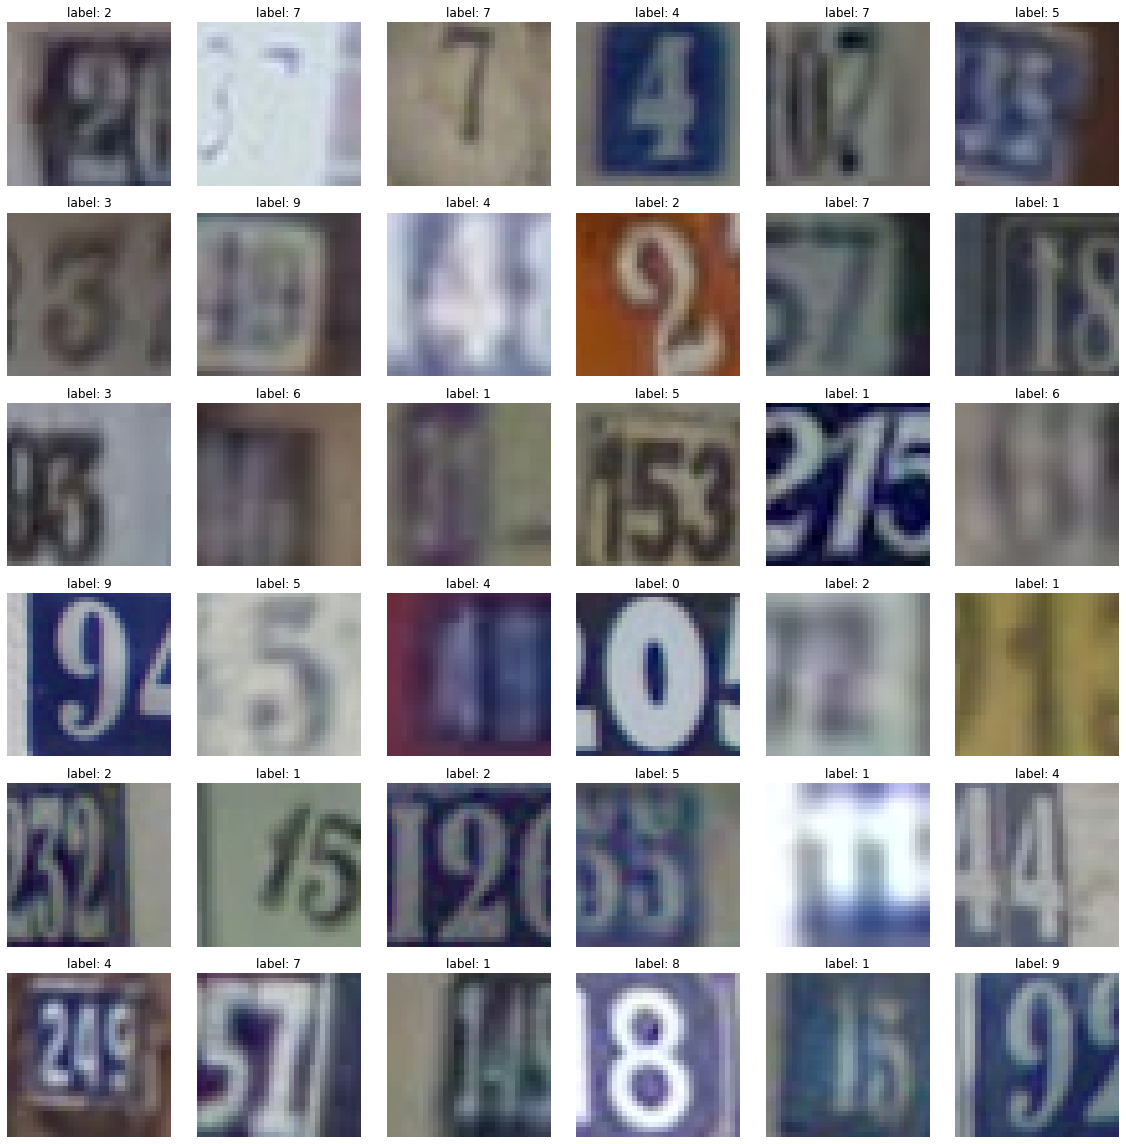

In [6]:
utils.visualize_data(trainset)

In [7]:
!nvidia-smi

Mon Nov 22 03:12:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0    47W /  N/A |   3492MiB / 16102MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


In [9]:
def run_experiment(pooling_layers, experiment_name, scenarios):
    model = CNN_with_poolings(pooling_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_function = torch.nn.CrossEntropyLoss()
    reg_params = None

    train_loss, train_acc, val_loss, val_acc = utils.train(model, 
                                                     train_loader, 
                                                     val_loader, 
                                                     optimizer, 
                                                     loss_function, 
                                                     reg_function=None,
                                                     reg_params=reg_params,
                                                     max_epoch=max_epoch,
                                                     device=device)

    test_loss, test_acc, confusion_matrix = utils.evaluate(model, test_loader, loss_function, device=device)
    print("Test Loss : {} Test Acc: {}".format(test_loss, test_acc))

    utils.visualize_loss_acc(train_loss, val_loss, train_acc, val_acc)
    utils.visualize_confusion_matrix(confusion_matrix)

    scenarios.append((experiment_name, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))
    return scenarios

## Training CNN

### Max Pooling

epoch 39 train acc: 0.8789 val acc: 0.8707 train loss: 0.4513 val loss: 0.4796: 


Time:  201.1564703200129
Test Loss : 0.5374944671696308 Test Acc: 0.8610855800653595


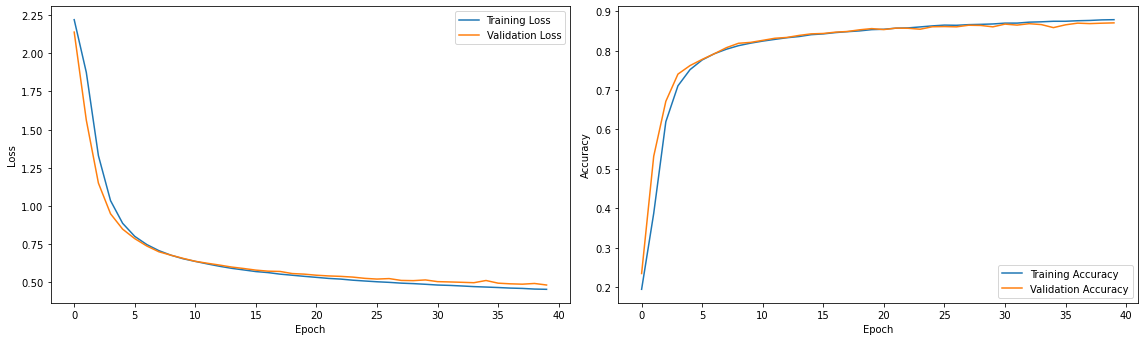

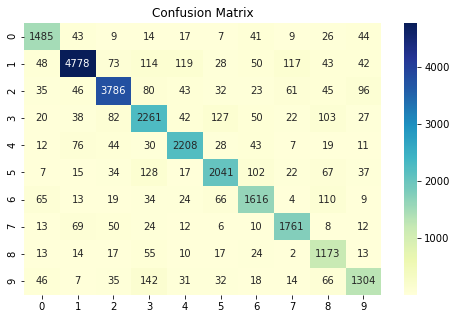

In [10]:
pooling_layers = [nn.MaxPool2d(kernel_size=2), nn.MaxPool2d(kernel_size=2)]
scenarios = run_experiment(pooling_layers, "CNN - Max Pooling", scenarios)

### Average Pooling

epoch 39 train acc: 0.8698 val acc: 0.8621 train loss: 0.474 val loss: 0.5037: 1


Time:  201.46495118900202
Test Loss : 0.5507892950200567 Test Acc: 0.8532858455882353


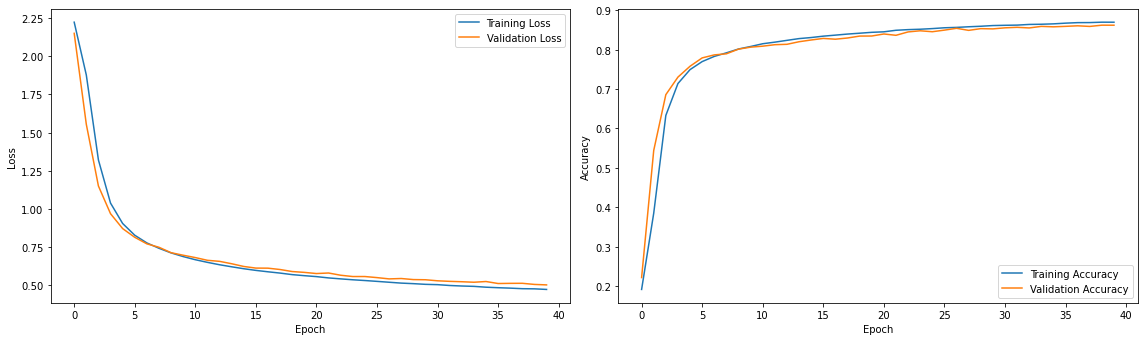

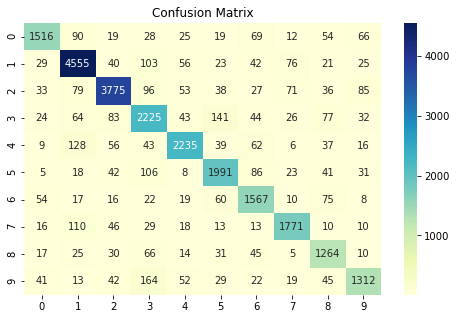

In [11]:
pooling_layers = [nn.AvgPool2d(kernel_size=2), nn.AvgPool2d(kernel_size=2)]
scenarios =run_experiment(pooling_layers, "CNN - Average Pooling", scenarios)

### Max Pooling - Average Pooling Respectively

epoch 39 train acc: 0.8748 val acc: 0.8684 train loss: 0.4506 val loss: 0.475: 1


Time:  205.52298954699654
Test Loss : 0.5263955731894455 Test Acc: 0.8544602736928105


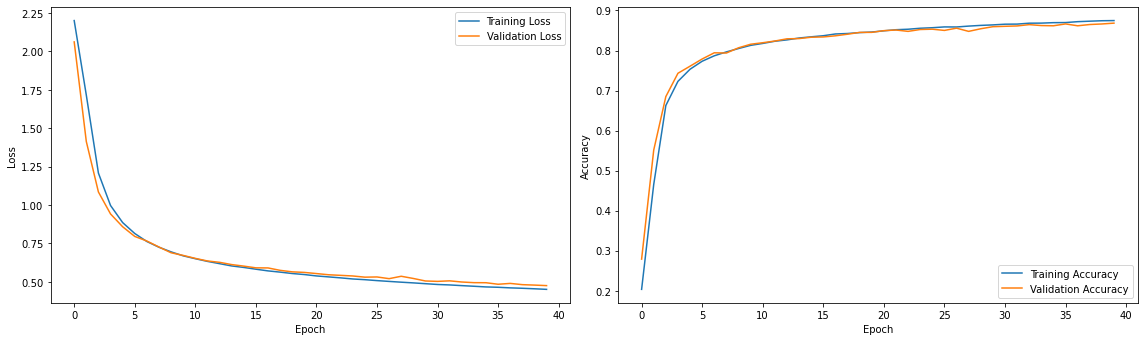

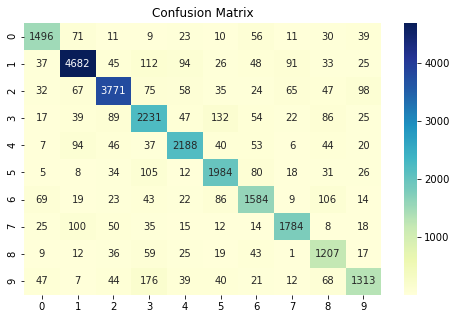

In [12]:
pooling_layers = [nn.MaxPool2d(kernel_size=2), nn.AvgPool2d(kernel_size=2)]
scenarios =run_experiment(pooling_layers, "CNN - Max-Average Pooling", scenarios)

### Average Pooling - Max Pooling Respectively

epoch 39 train acc: 0.8828 val acc: 0.8753 train loss: 0.4324 val loss: 0.4782: 


Time:  206.5479187569872
Test Loss : 0.5214261076613969 Test Acc: 0.86328125


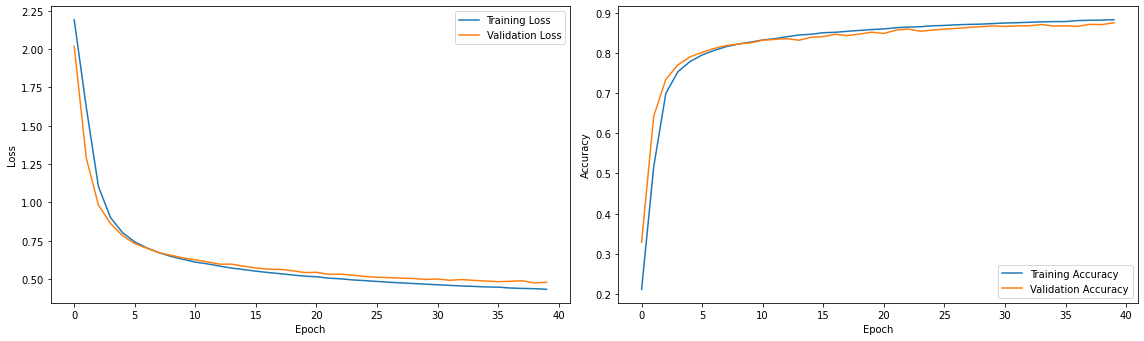

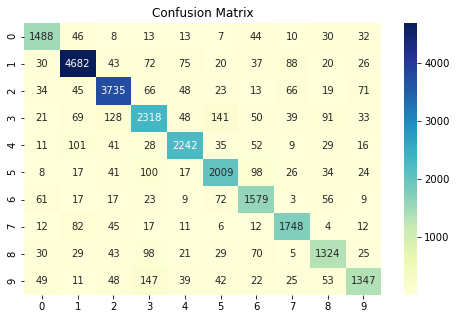

In [13]:
pooling_layers = [nn.AvgPool2d(kernel_size=2), nn.MaxPool2d(kernel_size=2)]
scenarios =run_experiment(pooling_layers, "CNN - Average-Max Pooling", scenarios)

## Plot & Compare All Scenarios

CNN - Max Pooling Test Accuracy: 0.861
CNN - Average Pooling Test Accuracy: 0.853
CNN - Max-Average Pooling Test Accuracy: 0.854
CNN - Average-Max Pooling Test Accuracy: 0.863


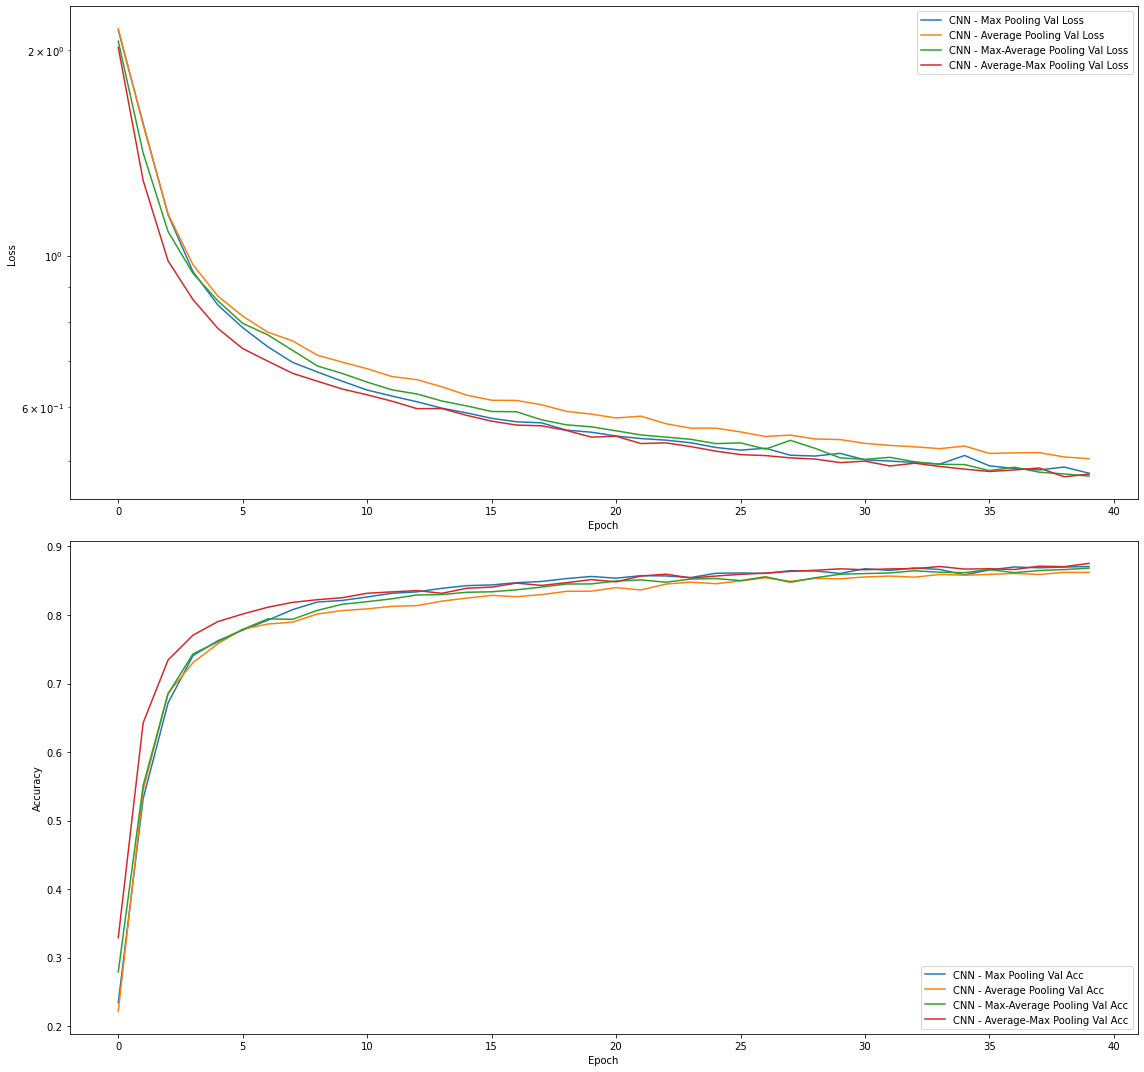

In [14]:
utils.plot_all(scenarios)

In [15]:
pickle.dump(scenarios, open( "CNNsPoolingComparisonScenarios.p", "wb" ) )